In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import sys, copy, emcee, corner
%matplotlib inline

In [2]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit by dilfactor'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

def k1mod(params,ligs,noise=None):
    '''
    theoretical model for single binding site
    
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    sat = (k1*ligs)/(1 + k1*ligs)

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def k2mod(params,ligs,noise=None):
    '''
    theoretical model for a two-site receptor
    
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    k2 = params[1]
    sat = (1/2)*((k1*ligs + 2*k1*k2*(ligs**2))/(1 + k1*ligs + k1*k2*(ligs**2)))

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def k2mod_fix(params,ligs,noise=None):
    '''
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    k2 = params[0]/4
    sat = (1/2)*((k1*ligs + 2*k1*k2*(ligs**2))/(1 + k1*ligs + k1*k2*(ligs**2)))

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def obj(guess,model,data):
    return model(guess,data[0])[1] - data[1]

#removed proportionality constant
def obj_wt(guess,model,data):
    return (model(guess,data[0])[1] - data[1])/(data[1])

def fit(data,model,guess):
        return sp.optimize.least_squares(obj,guess,args=(model,data),ftol=1e-14,gtol=1e-14,xtol=1e-14)

#removed proportionality constant    
def fit_wt(data,model,guess):
        return sp.optimize.least_squares(obj_wt,guess,args=(model,data),ftol=1e-14,gtol=1e-14,xtol=1e-14)

def ftest(fit1,fit2):
    '''
    fit1 is fit from simpler model
    '''

    SS1 = np.sum(np.square(fit1.fun))
    SS2 = np.sum(np.square(fit2.fun))

    DF1 = fit1.fun.shape[0] - fit1.x.shape[0]
    DF2 = fit2.fun.shape[0] - fit2.x.shape[0]

    F = ((SS1-SS2)/(DF1-DF2))/(SS2/DF2)

    p = sp.stats.f.sf(F,(DF1-DF2),DF2)

    return (SS1,SS2,DF1,DF2,F,p)

In [3]:
ligs = dilser()

In [4]:
k1parm = np.array([1.])

In [11]:
k1datset = [k1mod(k1parm,ligs,0.05) for i in range(10000)]

In [12]:
guess_2_param = np.array([2.,0.5])
guess_1_param = np.array([2.])

In [13]:
k2fits = [fit(i,k2mod,guess_2_param) for i in k1datset]

In [14]:
k1fits_nested = [fit(i,k2mod_fix,guess_1_param) for i in k1datset]

In [15]:
ps = np.array([ftest(k1fits_nested[i],k2fits[i])[-1] for i in range(10000)])

In [42]:
np.sum(ps<0.05)

694

In [17]:
ratios_k2 = np.array([i.x[0]/i.x[1] for i in k2fits])
k1s = np.array([i.x[0] for i in k1fits_nested])

In [18]:
sigfits = ratios_k2[(ps<0.05)]

In [19]:
negs = sigfits[(sigfits>4)]
pos = sigfits[(sigfits<4)]

(array([  9.,  17.,  36.,  52.,  58.,  69.,  41.,  21.,   6.,   1.]),
 array([ 1.41024386,  1.61000302,  1.80976217,  2.00952133,  2.20928048,
         2.40903964,  2.6087988 ,  2.80855795,  3.00831711,  3.20807626,
         3.40783542]),
 <a list of 10 Patch objects>)

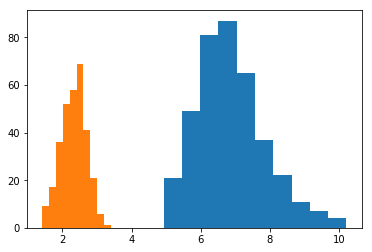

In [20]:
plt.hist(negs)
plt.hist(pos)

In [22]:
k2fits_wt = [fit_wt(i,k2mod,guess_2_param) for i in k1datset]

In [23]:
k1fits_nested_wt = [fit_wt(i,k2mod_fix,guess_1_param) for i in k1datset]

In [24]:
k1s_mod2 = np.array([i.x[0] for i in k2fits])
k1s_nest = np.array([i.x[0] for i in k1fits_nested])

(array([   25.,   181.,   789.,  1915.,  2937.,  2421.,  1282.,   372.,
           61.,    17.]),
 array([ 1.6036565 ,  1.68772135,  1.77178619,  1.85585103,  1.93991588,
         2.02398072,  2.10804556,  2.19211041,  2.27617525,  2.36024009,
         2.44430494]),
 <a list of 10 Patch objects>)

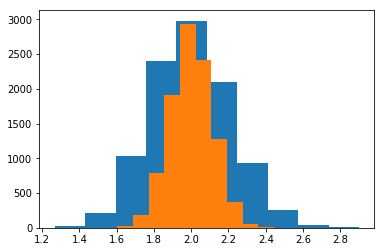

In [25]:
plt.hist(k1s_mod2)
plt.hist(k1s_nest)

In [26]:
k1s_mod2_wt = np.array([i.x[0] for i in k2fits_wt])
k1s_nest_wt = np.array([i.x[0] for i in k1fits_nested_wt])

(array([   10.,   116.,   492.,  1556.,  2598.,  2740.,  1690.,   629.,
          149.,    20.]),
 array([ 1.86383736,  1.88860123,  1.91336511,  1.93812898,  1.96289286,
         1.98765673,  2.01242061,  2.03718448,  2.06194836,  2.08671223,
         2.11147611]),
 <a list of 10 Patch objects>)

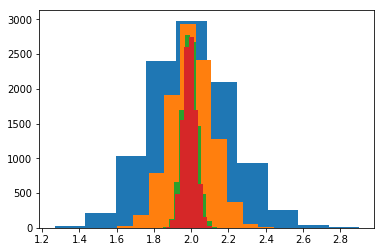

In [27]:
plt.hist(k1s_mod2)
plt.hist(k1s_nest)
plt.hist(k1s_mod2_wt)
plt.hist(k1s_nest_wt)

{'boxes': [<matplotlib.lines.Line2D at 0x11ac697b8>,
 'caps': [<matplotlib.lines.Line2D at 0x11ac6ff28>,
 'fliers': [<matplotlib.lines.Line2D at 0x11ac78d30>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11ac78358>,
 'whiskers': [<matplotlib.lines.Line2D at 0x11ac69a58>,
  <matplotlib.lines.Line2D at 0x11ad8bf28>]}

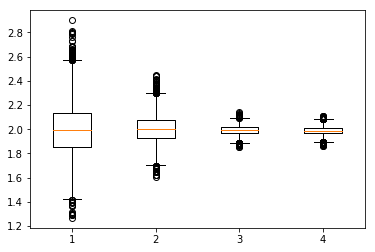

In [28]:
plt.boxplot([k1s_mod2,k1s_nest,k1s_mod2_wt,k1s_nest_wt])

In [29]:
ps_wt = np.array([ftest(k1fits_nested_wt[i],k2fits_wt[i])[-1] for i in range(10000)])

In [30]:
np.sum(ps_wt<0.05)

533

In [31]:
k2fits_wt_ratios = np.array([i.x[0]/i.x[1] for i in k2fits_wt])

In [32]:
sigfits_wt = k2fits_wt_ratios[(ps_wt<0.05)]

In [33]:
np.sum(sigfits_wt < 4)

176

(array([ 21.,  49.,  81.,  87.,  65.,  37.,  22.,  11.,   7.,   4.]),
 array([  4.9268707 ,   5.45605076,   5.98523082,   6.51441089,
          7.04359095,   7.57277101,   8.10195108,   8.63113114,
          9.1603112 ,   9.68949127,  10.21867133]),
 <a list of 10 Patch objects>)

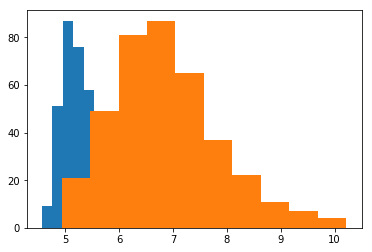

In [34]:
plt.hist(sigfits_wt[sigfits_wt>4])
plt.hist(sigfits[sigfits>4])

In [35]:
np.mean(sigfits_wt[sigfits_wt>4]) , np.mean(sigfits[sigfits>4])

(5.2790120146471393, 6.8575196421308364)

In [41]:
sigfits_wt.shape

(533,)